The python scripts in the DOI-MachineLearning have some differences from this notebook. However, the python scripts are all adapted directly from this notebook and achieve the same results.

For instance, the python scripts have additional functions to help streamline the pipeline when running from bash... To see a run down of the bash pipeline see the section Pipeline Appendix in the report.

In [2]:
import tensorflow as tf
from tensorflow.python.ops import resources
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap.umap_ as umap
from tqdm import tqdm
import matplotlib.patches as mpatches

## Technical functions specific to our detector setup
- converts the readout electronic's pixel IDs to more intuitive, chonrological IDs

In [3]:
# the data of interest was collected in these detector channels
DOIchannels = [72, 73, 80, 81, 88, 89, 96, 97]

roughChannels = np.array([[ 78,  73],
                 [ 79,  72],
                 [ 86,  81],
                 [ 87,  80],
                 [ 94,  89],
                 [ 95,  88],
                 [102,  97],
                 [103,  96]])

#converts PETSys ID to geometric ID ; the d
def toGeo(x):
    y = 8*indices.get(x)[0] + indices.get(x)[1]
    return y

indices = {
      0 : (4,7-7),
      1 : (4,7-6),
      2 : (7,7-5),
      3 : (5,7-7),
      4 : (5,7-4),
      5 : (5,7-5),
      6 : (4,7-4),
      7 : (7,7-7),
      8 : (6,7-6),
      9 : (7,7-4),
      10 : (5,7-6),
      11 : (6,7-4),
      12 : (4,7-5),
      13 : (6,7-5),
      14 : (6,7-7),
      15 : (7,7-6),
      16 : (3,7-7),
      17 : (3,7-6),
      18 : (2,7-7),
      19 : (2,7-6),
      20 : (0,7-7),
      21 : (1,7-7),
      22 : (0,7-6),
      23 : (1,7-6),
      24 : (3,7-5),
      25 : (1,7-5),
      26 : (2,7-5),
      27 : (4,7-3),
      28 : (0,7-5),
      29 : (3,7-4),
      30 : (0,7-4),
      31 : (1,7-4),
      32 : (2,7-4),
      33 : (3,7-3),
      34 : (2,7-3),
      35 : (0,7-3),
      36 : (1,7-3),
      37 : (0,7-2),
      38 : (5,7-3),
      39 : (1,7-2),
      40 : (2,7-2),
      41 : (3,7-2),
      42 : (1,7-1),
      43 : (0,7-1),
      44 : (0,7-0),
      45 : (3,7-1),
      46 : (1,7-0),
      47 : (2,7-1),
      48 : (3,7-0),
      49 : (2,7-0),
      50 : (6,7-2),
      51 : (6,7-1),
      52 : (7,7-1),
      53 : (4,7-1),
      54 : (5,7-1),
      55 : (6,7-0),
      56 : (7,7-0),
      57 : (7,7-2),
      58 : (7,7-3),
      59 : (4,7-2),
      60 : (5,7-0),
      61 : (5,7-2),
      62 : (6,7-3),
      63 : (4,7-0),
      64:(3+8,7),
      65:(3+8,6),
      66:(2+8,4),
      67:(2+8,6),
      68:(3+8,4),
      69:(1+8,7),
      70:(1+8,5),
      71:(0+8,7),
      72:(1+8,6),
      73:(3+8,3),
      74:(2+8,7),
      75:(2+8,3),
      76:(3+8,5),
      77:(0+8,5),
      78:(2+8,5),
      79:(0+8,6),
      80:(4+8,7),
      81:(6+8,7),
      82:(5+8,7),
      83:(7+8,7),
      84:(5+8,6),
      85:(4+8,6),
      86:(6+8,6),
      87:(7+8,6),
      88:(4+8,5),
      89:(6+8,5),
      90:(5+8,5),
      91:(1+8,4),
      92:(7+8,5),
      93:(7+8,4),
      94:(6+8,4),
      95:(4+8,4),
      96:(5+8,4),
      97:(5+8,3),
      98:(6+8,3),
      99:(4+8,3),
      100:(7+8,3),
      101:(7+8,2),
      102:(0+8,4),
      103:(6+8,2),
      104:(7+8,1),
      105:(5+8,2),
      106:(6+8,1),
      107:(4+8,2),
      108:(7+8,0),
      109:(5+8,1),
      110:(6+8,0),
      111:(4+8,1),
      112:(5+8,0),
      113:(4+8,0),
      114:(0+8,2),
      115:(2+8,1),
      116:(0+8,1),
      117:(3+8,1),
      118:(1+8,1),
      119:(1+8,0),
      120:(0+8,0),
      121:(1+8,2),
      122:(1+8,3),
      123:(3+8,2),
      124:(2+8,0),
      125:(2+8,2),
      126:(0+8,3),
      127:(3+8,0)}

geo_channels = []
for i in range(128):
    geo_channels.append([i,toGeo(i)])
geo_channels = np.asarray(geo_channels)
    
def toGeoChannelID(x):
    x = x % 128
    y = 8 * indices.get(x)[0] + indices.get(x)[1]
    return y

## Data Read-In Functions

In [4]:
# file = /path/to/datafile
# DOI = truth DOI from experiment 
# toGeo = convert channelIDs into geometric IDs
# train_and_test = (T/F split into training & testing ; training size ; testing size)
def getDOIDataFrame(file,DOI,toGeo = True,train_and_test = (True,0,0)):
    df = pd.read_csv(file, delimiter="\t", usecols=(2,3,4,12,13,14))
    df.columns = ["TimeL", "ChargeL", "ChannelIDL", "TimeR", "ChargeR", "ChannelIDR"]
    df["DOI"] = np.array([DOI]*np.shape(df)[0])

    if toGeo == True:
        df['ChannelIDL'] = df['ChannelIDL'].apply(toGeoChannelID)
        df['ChannelIDR'] = df['ChannelIDR'].apply(toGeoChannelID)
    
    # only select channels coupled to the rough crystals 
    df = df[(df["ChannelIDR"] == DOIchannels[0])
    | (df["ChannelIDR"] == DOIchannels[1])
    | (df["ChannelIDR"] == DOIchannels[2])
    | (df["ChannelIDR"] == DOIchannels[3])
    | (df["ChannelIDR"] == DOIchannels[4])
    | (df["ChannelIDR"] == DOIchannels[5])
    | (df["ChannelIDR"] == DOIchannels[6])
    | (df["ChannelIDR"] == DOIchannels[7])
    ]
    
    # reset index now that we've dropped the uninteresting rows of data
    df.index = np.arange(0,np.shape(df)[0],1)
    
    
    if train_and_test[0] == True:
        dfTraining = df[df.index < train_and_test[1]]
        dfTesting = df[(df.index > train_and_test[1]) & (df.index < train_and_test[2])]
        return dfTraining,dfTesting
    else:
        return df
    

def getChannelPairs(df,threshold):
    channelData = df[['ChannelIDL','ChannelIDR']]
    uniqueChannelPairs,Occurences = np.unique(channelData.to_numpy(),axis = 0,return_counts = True)
    mostActiveChannels = np.where(Occurences >= threshold)[0]
    uniqueChannelPairs = uniqueChannelPairs[mostActiveChannels]
    return uniqueChannelPairs

## Math Functions 

In [5]:
def gaussian(x,A,mu,sig):
    return A * np.exp(-((x-mu)/sig)**2)

## Pre-processing and analysis tools for DOI Machine Learning Project
- The cells below contains all analysis functions needed to complete pre-processing and analysis of DOI data.
- The results from these analyses codes will be used as our statistics for machine learning

In [6]:
# guessing the standard deviation helps isolate the photopeak before we fit to it
def getEnergySpectrum(df,channelID,side,bins,std_guess = 2,photopeakcut = 1.5,display = False):
    fig,ax = plt.subplots()
       
    if side == 'left':
        df_by_chan = df[df.ChannelIDL == channelID]
        energy = df_by_chan.ChargeL
    
    else:
        df_by_chan = df[df.ChannelIDR == channelID]
        energy = df_by_chan.ChargeR
    
    y,x = np.histogram(energy,bins[0],(bins[1],bins[2]))
    centers = (x[:-1] + x[1:]) / 2
    
    # this helps isolate the photopeak making it easier for the fitter to find it
    fitcut = centers[np.where(y == max(y))[0][0]] - std_guess
    
    energy_temp = energy[energy >= fitcut] 
    
    # redefine as we will fit to this cut data
    y,x = np.histogram(energy_temp,bins[0],(bins[1],bins[2]))
    centers = (x[:-1] + x[1:]) / 2
    

    guess = [max(y),centers[np.where(y == max(y))[0][0]],np.std(energy_temp)]
        
    try:
        p,c = curve_fit(gaussian,centers,y,p0=guess)
        xspace = np.linspace(p[1]-2.5*p[2],p[1]+2.5*p[2],500)
        ax.plot(xspace,gaussian(xspace,*p),color = 'red')
        ax.hist(energy,bins = np.linspace(bins[1],bins[2],bins[0]),color = 'C0')
        photopeak_counts = energy[(energy >= p[1] - photopeakcut*p[2]) & (energy <= p[1] + photopeakcut*p[2])]
    
    except:
        p = [-1,-1,-1]
        photopeak_counts = np.array([])
        print('Fit Failed')
        
    if display == False:
        plt.close()
        
    return p,photopeak_counts


# def plotEnergySpectrum()

# normalized count differences is a common metric used for DOI identification
def getNCD(left_Signal,right_signal):
    NCD = (left_Signal - right_signal)/((left_Signal + right_signal))
    return NCD



## Umap projection function
- must include DOI at the end of labels list

In [7]:
# get umap projection of the data

# df = (dataframe)
# labels = (names of columns we want to use)
# transform_to_zscore = (transforming to z-score can help the clustering algorithim)
def umapProjection(df,labels,transform_to_zscore = False):
    classes = ["2 mm","5 mm","10 mm","15 mm","20 mm","25 mm","28 mm"]
    colors = ['C0','C1','C2','C3','C4','C5','C6']
    # start umap instance and compute the dimensionality reduction
    reducer = umap.UMAP()
    umapLabels = labels
    umapData = df[umapLabels].values

    # sometimes helps with the clustering algorithim
    if transform_to_zscore == True:
        umapData = StandardScaler().fit_transform(umapData)

    umapData = reducer.fit_transform(umapData)
    
    # plot the projection
    fig,ax = plt.subplots(figsize = (10,7))
    scatter = ax.scatter(
        umapData[:, 0],
        umapData[:, 1],c = [sns.color_palette()[x] for x in df.DOI.map({2:0, 5:1, 10:2, 15:3 , 20:4 , 25:5, 28:6})])

    recs = []

    for i in range(0,len(colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))
    ax.legend(recs,classes,loc = 'best',fontsize = 13)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of DOI', fontsize=24);
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

## defining our training and testing datasets

In [8]:
# get our raw training and testing datasets, we'll start small for now
# all channels analysis

dir = 'DOI_Data/'
DOIs = [2,5,10,15,20,25,28]


trainingDataList = []
testingDataList = []

for depth in DOIs:
    training,testing = getDOIDataFrame('DOI_Data/28um_DOI_' + str(depth) + 'mm_coinc.txt',DOI=depth,train_and_test = (True,50000,70000))
    
    # shuffle the dataframe so our depths are random and not in order
    training = training.sample(frac = 1)
    testing = testing.sample(frac = 1)
    
    # only use populated channel pairs, less populated channel pairs are indictaive of connection via scattering.
    trainingPairs =  roughChannels
    testingPairs = trainingPairs #getChannelPairs(testing,350)
    
    for channelpairTrain,channelpairTest in zip(trainingPairs,testingPairs):
        
        training2 = training[(training.ChannelIDL == channelpairTrain[0]) & (training.ChannelIDR == channelpairTrain[1])]
        testing2 = testing[(testing.ChannelIDL == channelpairTest[0]) & (testing.ChannelIDR == channelpairTest[1])]
        
        trainingDataList.append(training2)
        testingDataList.append(testing2)
    
# convert back into dataframes & reset the index
trainingData = pd.concat(trainingDataList,ignore_index=True)
testingData = pd.concat(testingDataList,ignore_index=True)

print(np.shape(trainingData),np.shape(testingData))

(337744, 7) (135032, 7)


### Fit to energy and then impose the photopeak energy cut on our datafranes
- a bit of tedious code because we need to do this for both left & right detectors and both training & testing data

In [9]:
run_energy_cut = True

energy_bins = (100,0,40)
energyCut = 2 # number of sigma away from photopeak mean we want to keep 


# for each channel pair, histogram its energy and fit to it then remove channels that don't fall into the photopeak
if run_energy_cut == True:

    energyCutDict = {'ChannelID':[],'energyCut':[],'DOI':[]}
    for chanL in tqdm(np.unique(trainingData.ChannelIDL)):
        for depth in DOIs:
            tempdf = trainingData[trainingData.DOI == depth]
            p,_ = getEnergySpectrum(tempdf,chanL,'left',bins=energy_bins)
            energyCutDict['ChannelID'] += [chanL]
            energyCutDict['energyCut'] += [[p[1]-energyCut*p[2],p[1]+energyCut*p[2]]]
            energyCutDict['DOI'] += [depth]
            
    for chanR in tqdm(np.unique(trainingData.ChannelIDR)):
        for depth in DOIs:
            tempdf = trainingData[trainingData.DOI == depth]
            p,_ = getEnergySpectrum(tempdf,chanR,'right',bins=energy_bins)
            energyCutDict['ChannelID'] += [chanR]
            energyCutDict['energyCut'] += [[p[1]-energyCut*p[2],p[1]+energyCut*p[2]]]
            energyCutDict['DOI'] += [depth]
        
    energyCutDf = pd.DataFrame(energyCutDict)

    trainingArray = trainingData.to_numpy()
    trainingDictEnergyCut = {"TimeL":[], "ChargeL":[], "ChannelIDL":[], "TimeR":[], "ChargeR":[], "ChannelIDR":[],'DOI':[]}
    
    for rownum in tqdm(range(len(trainingArray))):
        row = trainingArray[rownum]
        
        # get the energy cut for each channel at the given DOI 
        ch1_cut = energyCutDf[(energyCutDf.ChannelID == row[2]) & (energyCutDf.DOI == row[6])].energyCut.iloc[0]
        ch1_lower_limit,ch1_upper_limit = ch1_cut[0],ch1_cut[1]                        
        ch2_cut = energyCutDf[(energyCutDf.ChannelID == row[5]) & (energyCutDf.DOI == row[6])].energyCut.iloc[0]
        ch2_lower_limit,ch2_upper_limit = ch2_cut[0],ch2_cut[1]
        
        energy1,energy2 = row[1],row[4]
        
        
        if energy1>=ch1_lower_limit and energy1 <=ch1_upper_limit and energy2>=ch2_lower_limit and energy2 <=ch2_upper_limit:
            trainingDictEnergyCut["TimeL"] += [row[0]]
            trainingDictEnergyCut["ChargeL"] += [row[1]]
            trainingDictEnergyCut["ChannelIDL"] += [row[2]]
            trainingDictEnergyCut["TimeR"] += [row[3]]
            trainingDictEnergyCut["ChargeR"] += [row[4]]
            trainingDictEnergyCut["ChannelIDR"] += [row[5]]
        
            trainingDictEnergyCut["DOI"] += [row[6]]
        
    trainingData = pd.DataFrame(trainingDictEnergyCut) # redefine training data with energy cut


# ###############################################################
# ###############################################################
# ########################### Testing Data ######################
# ###############################################################
# ###############################################################


    energyCutDict = {'ChannelID':[],'energyCut':[],'DOI':[]}
    for chanL in tqdm(np.unique(testingData.ChannelIDL)):
        for depth in DOIs:
            tempdf = testingData[testingData.DOI == depth]
            p,_ = getEnergySpectrum(tempdf,chanL,'left',bins=energy_bins)
            energyCutDict['ChannelID'] += [chanL]
            energyCutDict['energyCut'] += [[p[1]-energyCut*p[2],p[1]+energyCut*p[2]]]
            energyCutDict['DOI'] += [depth]
            
    for chanR in tqdm(np.unique(testingData.ChannelIDR)):
        for depth in DOIs:
            tempdf = testingData[testingData.DOI == depth]
            p,_ = getEnergySpectrum(tempdf,chanR,'right',bins=energy_bins)
            energyCutDict['ChannelID'] += [chanR]
            energyCutDict['energyCut'] += [[p[1]-energyCut*p[2],p[1]+energyCut*p[2]]]
            energyCutDict['DOI'] += [depth]
        
    energyCutDf = pd.DataFrame(energyCutDict)

    testingArray = testingData.to_numpy()
    testingDictEnergyCut = {"TimeL":[], "ChargeL":[], "ChannelIDL":[], "TimeR":[], "ChargeR":[], "ChannelIDR":[],'DOI':[]}
    
    for rownum in tqdm(range(len(testingArray))):
        row = testingArray[rownum]
        
        ch1_cut = energyCutDf[(energyCutDf.ChannelID == row[2]) & (energyCutDf.DOI == row[6])].energyCut.iloc[0]
        ch1_lower_limit,ch1_upper_limit = ch1_cut[0],ch1_cut[1]                        
        ch2_cut = energyCutDf[(energyCutDf.ChannelID == row[5]) & (energyCutDf.DOI == row[6])].energyCut.iloc[0]
        ch2_lower_limit,ch2_upper_limit = ch2_cut[0],ch2_cut[1]
        
        energy1,energy2 = row[1],row[4]
        
        if energy1>=ch1_lower_limit and energy1 <=ch1_upper_limit and energy2>=ch2_lower_limit and energy2 <=ch2_upper_limit:
            testingDictEnergyCut["TimeL"] += [row[0]]
            testingDictEnergyCut["ChargeL"] += [row[1]]
            testingDictEnergyCut["ChannelIDL"] += [row[2]]
            
            testingDictEnergyCut["TimeR"] += [row[3]]
            testingDictEnergyCut["ChargeR"] += [row[4]]
            testingDictEnergyCut["ChannelIDR"] += [row[5]]
        
            testingDictEnergyCut["DOI"] += [row[6]]
        
    testingData = pd.DataFrame(testingDictEnergyCut)

print(np.shape(trainingData),np.shape(testingData))

100%|█████████████████████████████████| 135032/135032 [00:52<00:00, 2581.92it/s]


(90506, 7) (35815, 7)


In [10]:
trainingData['NCD'] = ((trainingData.ChargeL - trainingData.ChargeR)/(trainingData.ChargeR + trainingData.ChargeL))
trainingData['delta_t'] = (trainingData.TimeL - trainingData.TimeR)
trainingData['delta_t'] = trainingData['delta_t'] - np.mean(trainingData['delta_t'])
testingData['NCD'] = ((testingData.ChargeL - testingData.ChargeR)/(testingData.ChargeR + testingData.ChargeL))
testingData['delta_t'] = (testingData.TimeL - testingData.TimeR)
testingData['delta_t'] = testingData['delta_t'] - np.mean(testingData['delta_t'])

UMAP(n_components=3, output_metric='chebyshev', random_state=42, verbose=True)
Sun Nov 26 11:59:18 2023 Construct fuzzy simplicial set
Sun Nov 26 11:59:18 2023 Finding Nearest Neighbors
Sun Nov 26 11:59:18 2023 Building RP forest with 20 trees
Sun Nov 26 11:59:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sun Nov 26 12:03:49 2023 Finished Nearest Neighbor Search
Sun Nov 26 12:03:50 2023 Construct embedding


Epochs completed: 100%| ████████████████████████████████████████ 200/200 [00:46]
/Users/feef/Library/Python/3.9/lib/python/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Sun Nov 26 12:04:42 2023 Finished embedding
Sun Nov 26 12:04:43 2023 Worst tree score: 0.99133759
Sun Nov 26 12:04:43 2023 Mean tree score: 0.99204031
Sun Nov 26 12:04:43 2023 Best tree score: 0.99265242
Sun Nov 26 12:04:44 2023 Forward diversification reduced edges from 1357590 to 368935
Sun Nov 26 12:04:46 2023 Reverse diversification reduced edges from 368935 to 368935
Sun Nov 26 12:04:46 2023 Degree pruning reduced edges from 317868 to 317868
Sun Nov 26 12:04:46 2023 Resorting data and graph based on tree order
Sun Nov 26 12:04:46 2023 Building and compiling search function


Epochs completed: 100%| ██████████████████████████████████████████ 30/30 [00:02]
/Users/feef/Library/Python/3.9/lib/python/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


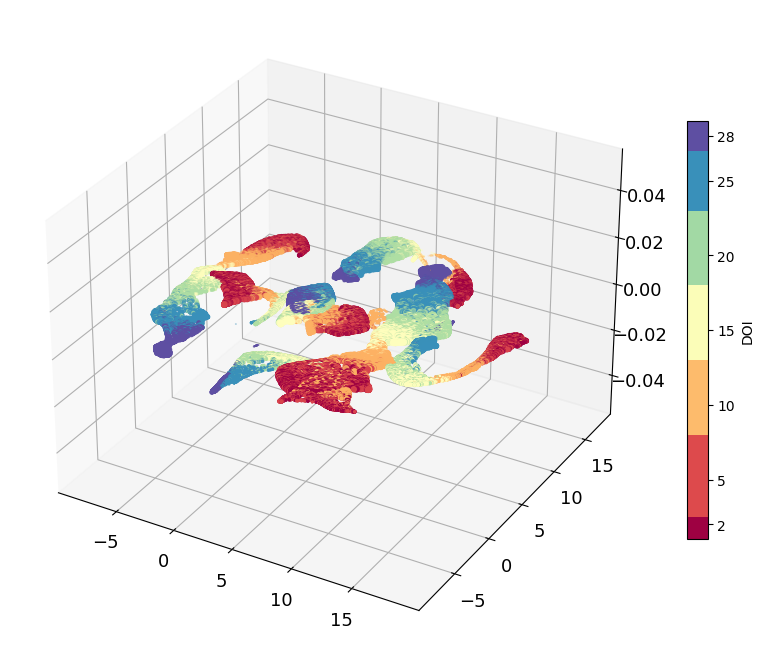

In [11]:
x = ['NCD','ChargeR','ChargeL',"ChannelIDL","ChannelIDR"]
y = ['DOI']

xTrain = trainingData[x]
yTrain = trainingData[y]
xTest = testingData[x]
yTest = testingData[y]

staticReduction = umap.UMAP(output_metric = "chebyshev",n_components=3,random_state=42,verbose=True).fit(xTrain)


# plot the projection to see what its doing
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(projection='3d')

n1 = staticReduction.embedding_[:,0]
n2 = staticReduction.embedding_[:,1]
n3 = staticReduction.embedding_[:,2]
# n4 = staticReduction.embedding_[:,3]
DOIdensity = trainingData.DOI.to_numpy()

scatter = plt.scatter(n1,n2,n3,c=DOIdensity,cmap='Spectral')

bounds = [2,5,10,15,20,25,28,30] #DOIs
fakebounds = [2-1,5-2.5,10-2,15-2,20-2,25-2,28-1,30-1]

cbar = plt.colorbar(scatter,spacing='proportional', ticks=bounds, boundaries=np.array(fakebounds), format='%1i',label = 'DOI',fraction=0.03)
ax.tick_params("z",labelsize = 13)
ax.tick_params("y",labelsize = 13)
ax.tick_params("x",labelsize = 13)


testEmbeddings = staticReduction.transform(xTest)

In [12]:
trainingData['n1'] = n1
trainingData['n2'] = n2
trainingData['n3'] = n3
testingData['n1'] = testEmbeddings[:,0]
testingData['n2'] = testEmbeddings[:,1]
testingData['n3'] = testEmbeddings[:,2]

### this is a nice processing trick. Transform charge to z-score but do it per channel's charges

In [13]:
import scipy.stats as stats

def zscore_by_channel(df,col_name):
    zscoredData = []
    for chans in roughChannels:
        tempdf = df[(df.ChannelIDL == chans[0]) & (df.ChannelIDR == chans[1])]
        zscoredData.extend(stats.zscore(tempdf[col_name]))
    return zscoredData

rightNorms = []
leftNorms = []
for p in trainingPairs:
    tempdf = trainingData[(trainingData.ChannelIDL == p[0]) & (trainingData.ChannelIDR == p[1])]
    rightNorms.extend(stats.zscore(tempdf['ChargeR']))
    leftNorms.extend(stats.zscore(tempdf['ChargeL']))
    
trainingData['ChargeL_zscore'] = np.array(leftNorms)
trainingData['ChargeR_zscore'] = np.array(rightNorms)

rightNorms = []
leftNorms = []
for p in trainingPairs:
    tempdf = testingData[(testingData.ChannelIDL == p[0]) & (testingData.ChannelIDR == p[1])]
    rightNorms.extend(stats.zscore(tempdf['ChargeR']))
    leftNorms.extend(stats.zscore(tempdf['ChargeL']))
    
testingData['ChargeL_zscore'] = np.array(leftNorms)
testingData['ChargeR_zscore'] = np.array(rightNorms)

In [14]:
# shuffle our datasets

trainingData = trainingData.sample(n=np.shape(trainingData)[0])
testingData = testingData.sample(n=np.shape(testingData)[0])

In [15]:
features = ['ChannelIDL','ChannelIDR','NCD','delta_t','ChargeR','ChargeL',"ChargeR_zscore","ChargeL_zscore",'DOI']

kerasTrainingFrame = tfdf.keras.pd_dataframe_to_tf_dataset(trainingData[features], label="DOI")
kerasPredictionFrame = tfdf.keras.pd_dataframe_to_tf_dataset(testingData[features], label="DOI")

In [16]:
model = tfdf.keras.RandomForestModel(verbose=2,max_depth = 20)
model.fit(kerasTrainingFrame,label='DOI')

Use 12 thread(s) for training
Use /var/folders/0q/5c4bcz6n2jlc82f86_hqdm1m0000gn/T/tmpg8cr3guv as temporary training directory


Reading training dataset...
Training tensor examples:
Features: {'ChannelIDL': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'ChannelIDR': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'NCD': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'delta_t': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'ChargeR': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'ChargeL': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'ChargeR_zscore': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'ChargeL_zscore': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>}
Label: Tensor("data_8:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'ChannelIDL': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'ChannelIDR': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'NCD': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor

[INFO 23-11-26 12:05:30.5676 CST kernel.cc:773] Start Yggdrasil model training
[INFO 23-11-26 12:05:30.5682 CST kernel.cc:774] Collect training examples
[INFO 23-11-26 12:05:30.5682 CST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-11-26 12:05:30.5684 CST kernel.cc:393] Number of batches: 91
[INFO 23-11-26 12:05:30.5684 CST kernel.cc:394] Number of examples: 90506
[INFO 23-11-26 12:05:30.5741 CST kernel.cc:794] Training dataset:
Number of records: 90506
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	0: "ChannelIDL" NUMERICAL mean:90.5126 min:78 max:103 s

Model trained in 0:00:14.224251
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [18]:
compilation = model.compile(metrics=["Accuracy"])
evaluation = model.evaluate(kerasPredictionFrame,return_dict=True)

36/36 [==============================] - 3s 78ms/step - loss: 0.0000e+00 - Accuracy: 0.8500


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

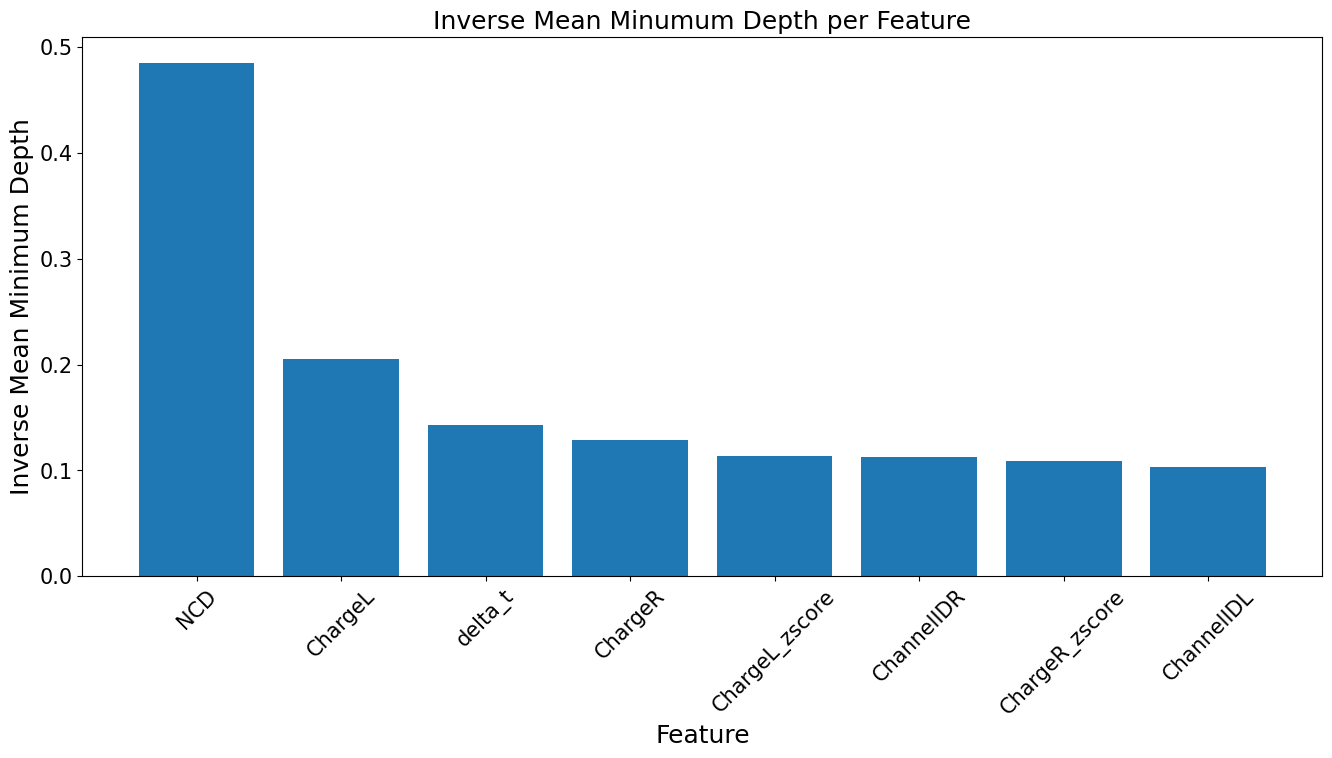

In [19]:
# plot inverse mean minimum 
importances = (model.make_inspector().variable_importances()['INV_MEAN_MIN_DEPTH'])
used_features = []
inv_mean_min_depth = []
for feats in importances:
    used_features.append(feats[0][0])
    inv_mean_min_depth.append(feats[1])
    
mean_min_depth = 1/np.array(inv_mean_min_depth)

fig,ax = plt.subplots(figsize = (16,7))
plt.bar(used_features,inv_mean_min_depth)
plt.title('Inverse Mean Minumum Depth per Feature',fontsize = 18)
plt.ylabel('Inverse Mean Minimum Depth',fontsize = 18)
plt.xlabel('Feature',fontsize = 18)
plt.xticks(fontsize = 15,rotation = 45)
plt.yticks(fontsize = 15)

In [20]:
# let's actually test our model
predict = model.predict(kerasPredictionFrame)
predict = np.argmax(predict, axis=1)
predict = predict.reshape(predict.shape[0], 1)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

36/36 [==============================] - 3s 75ms/step
loss: 0.0000
Accuracy: 0.8500


### print accuracy per category & plot the confusion matrix

Accuracy for 2 mm DOI: 0.72
Accuracy for 5 mm DOI: 0.73
Accuracy for 10 mm DOI: 0.949
Accuracy for 15 mm DOI: 0.77
Accuracy for 20 mm DOI: 0.91
Accuracy for 25 mm DOI: 0.9
Accuracy for 28 mm DOI: 0.97
Total Accuracy:  0.85


Text(0.5, 1.0, 'Confusion Matrix with a 2$\\sigma$ cut')

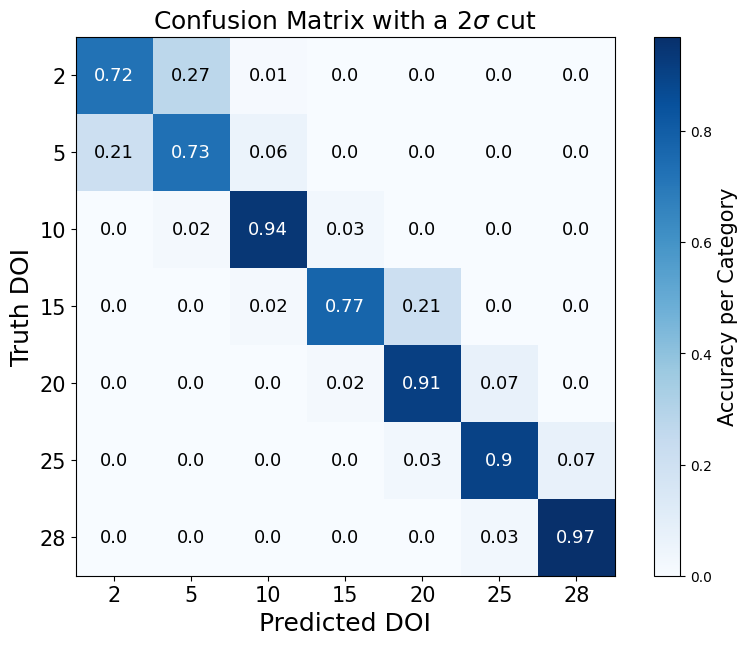

In [21]:
# checking accuracy per category!

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

normalize_per_category = True

# define our confusion matrix
matrix = np.transpose(confusion_matrix(predict,testingData.DOI))


if normalize_per_category == True:
    matrix = np.round(normalize(matrix,axis=1,norm='l1'),2)
    lowcolor = 0.7
else:
    lowcolor = 4000

DOI_index = 0
correct = 0
notCorrect = 0
for row in matrix:
    accuracy = row[DOI_index]/np.sum(row)
    correct += row[DOI_index]
    notCorrect += np.sum(row) - row[DOI_index]
    print('Accuracy for ' + str(DOIs[DOI_index]) + ' mm DOI:',np.round(accuracy,3))
    DOI_index += 1
print('Total Accuracy: ',np.round(correct/(correct + notCorrect),3))

# imshow will plot this by index in the list
doiIndices = np.arange(0,7,1)

fig,ax = plt.subplots(figsize = (10,7))
plt.imshow(matrix,cmap='Blues') 
plt.colorbar().set_label(label='Accuracy per Category',size=15)
plt.xticks(doiIndices,DOIs,fontsize = 15)
plt.yticks(doiIndices,DOIs,fontsize = 15)

for i in doiIndices:
    for j in doiIndices:
        if matrix[j,i] < lowcolor:
            plt.text(i,j,matrix[j,i],ha="center", va="center",c='black',fontsize = 13)
        else:
            plt.text(i,j,matrix[j,i],ha="center", va="center",c='w',fontsize = 13)

plt.ylabel('Truth DOI',fontsize = 18)
plt.xlabel('Predicted DOI',fontsize = 18)
plt.title('Confusion Matrix with a 2$\sigma$ cut',fontsize = 18)

## Regression Models for predicting continuous variables

In [22]:
features = ["NCD","ChargeR","ChargeL","ChargeR_zscore","ChargeL_zscore","delta_t","ChannelIDL","ChannelIDR",'DOI']
kerasTrainingFrame_Regression = tfdf.keras.pd_dataframe_to_tf_dataset(trainingData[features], label="DOI",task=tfdf.keras.Task.REGRESSION)
kerasTestingFrame_Regression = tfdf.keras.pd_dataframe_to_tf_dataset(testingData[features], label="DOI",task=tfdf.keras.Task.REGRESSION)

In [23]:
model_regression = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION,max_depth = 20)
model_regression.fit(kerasTrainingFrame_Regression)

Use /var/folders/0q/5c4bcz6n2jlc82f86_hqdm1m0000gn/T/tmp0f5oa2i2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.266419. Found 90506 examples.
Training model...


[INFO 23-11-26 12:06:10.5582 CST kernel.cc:1243] Loading model from path /var/folders/0q/5c4bcz6n2jlc82f86_hqdm1m0000gn/T/tmp0f5oa2i2/model/ with prefix 93feff0494784198
[INFO 23-11-26 12:06:13.5283 CST decision_forest.cc:660] Model loaded with 300 root(s), 2625970 node(s), and 8 input feature(s).
[INFO 23-11-26 12:06:13.5284 CST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-11-26 12:06:13.5284 CST kernel.cc:1075] Use fast generic engine


Model trained in 0:00:10.355123
Compiling model...
Model compiled.


In [24]:
model_regression.compile(metrics=["mse"])
evaluation = model_regression.evaluate(kerasTestingFrame_Regression, return_dict=True)

print(evaluation)
print()
print("MSE: {}".format(evaluation['mse']))
print("RMSE: {}".format(np.sqrt(evaluation['mse'])))

36/36 [==============================] - 2s 42ms/step - loss: 0.0000e+00 - mse: 1.9779
{'loss': 0.0, 'mse': 1.9778531789779663}

MSE: 1.9778531789779663
RMSE: 1.4063616814240802


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

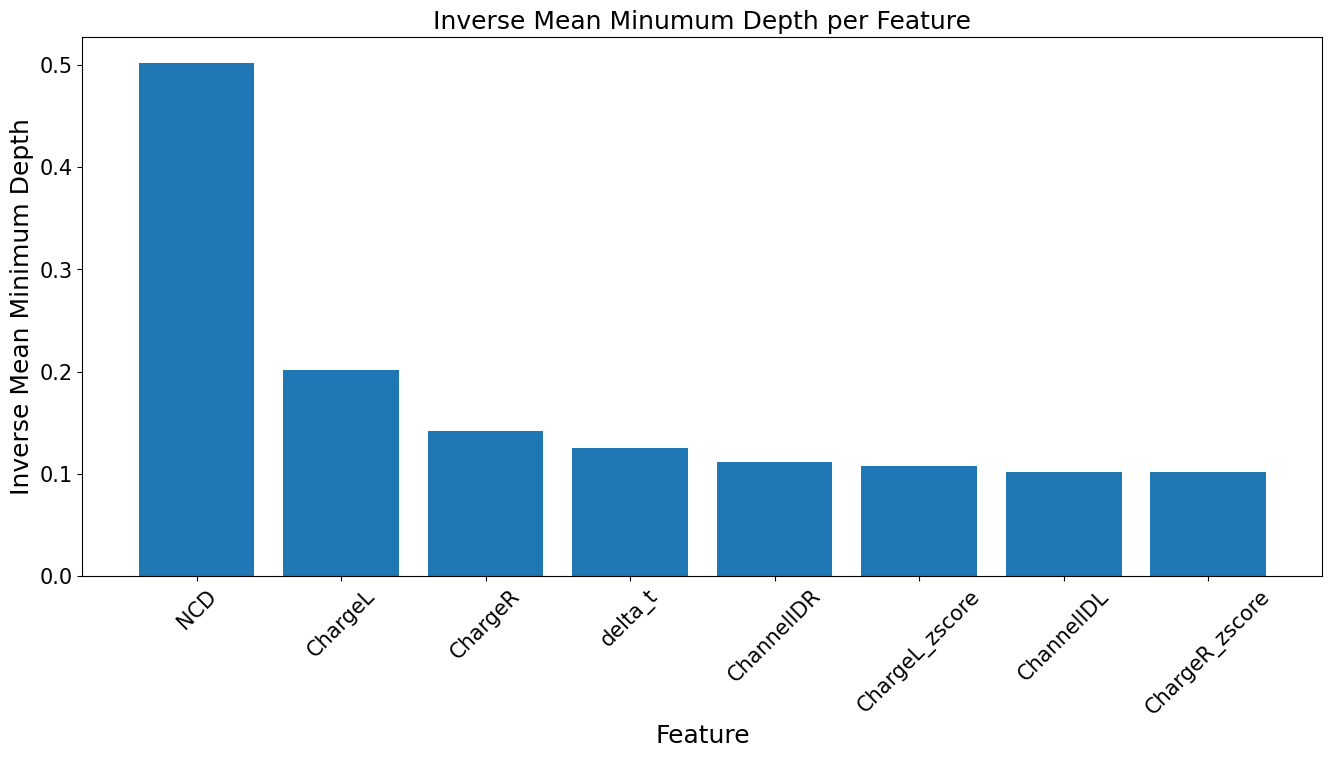

In [25]:
# plot inverse mean minimum 
importances = (model_regression.make_inspector().variable_importances()['INV_MEAN_MIN_DEPTH'])
used_features = []
inv_mean_min_depth = []
for feats in importances:
    used_features.append(feats[0][0])
    inv_mean_min_depth.append(feats[1])
    

fig,ax = plt.subplots(figsize = (16,7))
plt.bar(used_features,inv_mean_min_depth)
plt.title('Inverse Mean Minumum Depth per Feature',fontsize = 18)
plt.ylabel('Inverse Mean Minimum Depth',fontsize = 18)
plt.xlabel('Feature',fontsize = 18)
plt.xticks(fontsize = 15,rotation = 45)
plt.yticks(fontsize = 15)

In [26]:
prediction = model_regression.predict(kerasTestingFrame_Regression)

36/36 [==============================] - 1s 40ms/step


(0.0, 30.0)

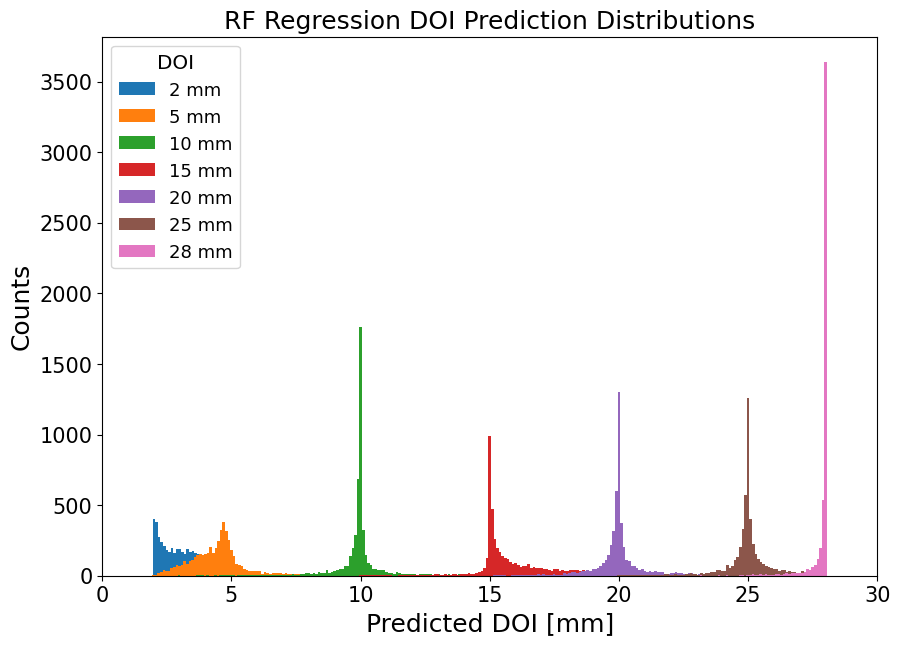

In [27]:
fig,ax = plt.subplots(figsize = (10,7))
newDOIs = DOIs[-1:]
for i in DOIs:
    whereDOI = np.where(testingData.DOI == i)[0]
    bins = np.linspace(i-10,i+10,200)
    y,x,_ = plt.hist(prediction[whereDOI],bins = bins,label = str(i) + ' mm')
plt.ylabel('Counts',fontsize = 18)
plt.xlabel('Predicted DOI [mm]',fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('RF Regression DOI Prediction Distributions',fontsize = 18)
leg = plt.legend(title = "DOI",fontsize = 13)
leg.set_title("DOI", prop = {'size':'x-large'})
plt.xlim(0,30)

In [28]:
resultFrame = pd.DataFrame(columns = ["ChannelIDL","ChannelIDR","Truth","Predicted"])
resultFrame["ChannelIDL"] = testingData.ChannelIDL
resultFrame["ChannelIDR"] = testingData.ChannelIDR
resultFrame["Truth"] = testingData.DOI
resultFrame["Predicted"] = prediction

In [29]:
N = np.shape(trainingData)[0]

omit_2_28 = True
print_averages = True


if omit_2_28 == True: # necessary due to the asymmetric distributions
    useDOIs = DOIs[1:6]
    
else:
    useDOIs = DOIs
    
resolutionFrame = pd.DataFrame(columns = ["ChannelIDL","ChannelIDR","DOI","FWHM","error","efficiency"])
currentIndex = 0
for channelL,channelR in zip(roughChannels[:,0],roughChannels[:,1]):
    for depth in useDOIs:
        
        # get all instances at specific channel and DOI
        whereDOI = np.where((resultFrame.ChannelIDL == channelL) & (resultFrame.Truth == depth))[0]

        data = resultFrame.Truth.to_numpy()[whereDOI] - resultFrame.Predicted.to_numpy()[whereDOI]
        
        y,x = np.histogram(data,50)
        centers = (x[:-1] + x[1:]) / 2
        try:
            
            # construct a reasonable guess for our fit
            a = np.where(y == max(y))[0][0]
            mu = centers[a]
            A = y[a]
            std = 0.1
            guess = [A,mu,std]
            
            
            # fit to Gaussian to DOI
            p,c = curve_fit(gaussian,centers,y)
            p = abs(p)
                       
            FWHM = p[2]*2.355
            ERR = np.sqrt(c[2,2])*2.355/np.sqrt(N) # standard error calculation
            
            # calculating efficiency
            inside = np.where((centers <= p[1] + 2.5*p[2]) & (centers >= p[1] - 2.5*p[2]))
            outside = np.where((centers >= p[1] + 2.5*p[2]) | (centers <= p[1] - 2.5*p[2]))
            yinside = y[inside]
            youtside = y[outside]
            
            efficiency = 1 - np.sum(youtside)/(np.sum(youtside) + np.sum(yinside))
            
            resolutionFrame.loc[currentIndex] = [channelL,channelR,depth,FWHM,ERR,efficiency]
            
            currentIndex += 1
        except:
            pass

if print_averages == True:
    print()
    if omit_2_28 == True:
        for depth in useDOIs:
            res = np.round(resolutionFrame[resolutionFrame.DOI == depth].FWHM.mean(),3)
            eff = np.round(resolutionFrame[resolutionFrame.DOI == depth].efficiency.mean(),3)
            print("Average Resolution at {} mm DOI: {} mm with {}% effciency".format(depth,res,eff*100))



Average Resolution at 5 mm DOI: 1.635 mm with 85.5% effciency
Average Resolution at 10 mm DOI: 0.455 mm with 73.5% effciency
Average Resolution at 15 mm DOI: 2.717 mm with 67.4% effciency
Average Resolution at 20 mm DOI: 0.525 mm with 68.89999999999999% effciency
Average Resolution at 25 mm DOI: 0.511 mm with 69.19999999999999% effciency
